# DataJoint Elements for Electrode Localization

#### Open-source data pipeline for localizing Neuropixels electrodes within the Allen brain atlas - [Allen Mouse Common Coordinate Framework (CCF)](https://atlas.brain-map.org/)

Welcome to the tutorial for the DataJoint Element for electrode localization. This tutorial aims to provide a comprehensive understanding of the open-source data pipeline created using `element-electrode-localization`.

This package is designed to seamlessly ingest and track **electrode localization** data using DataJoint. By the end of this tutorial, you will have a clear grasp on setting up  `element-electrode-localization` into your specific research projects and lab.


![flowchart](../images/flowchart.svg)

### Prerequisites
Please see the [datajoint tutorials GitHub repository](https://github.com/datajoint/datajoint-tutorials/tree/main) before proceeding.

#### **Tutorial Overview**
+ Setup
+ *Activate* the DataJoint pipeline.
+ Inspect and *query* tables from the coordinate framework schema.
+ View attributes and learn how to use the electrode localization tables.

### **Setup**
This tutorial examines the DataJoint tables that allow electrode localization of Neuropixels probes. The goal is to store, track, and manage all metadata associated with electrode localization and probe position, aligning to the Common Coordinate Framework (CCF) with the Allen Brain Atlas.

The results of this Element can be combined with **other modalities** to create a complete, customizable data pipeline for your specific lab or study. For instance, you can combine `element-electrode-localization` with `element-array-ephys` and `element-event` to characterize the neural activity during specific stimulus events.

Let's start this tutorial by importing the packages necessary to run the notebook.

In [1]:
import datajoint as dj

If the tutorial is run in Codespaces, a private, local database server is created and made available for you. This is where we will insert and store our processed results. Let's connect to the database server.

In [3]:
dj.conn()

[2024-01-27 02:24:58,458][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2024-01-27 02:24:58,466][INFO]: Connected root@fakeservices.datajoint.io:3306


DataJoint connection (connected) root@fakeservices.datajoint.io:3306

### **Activate the DataJoint Pipeline**

Now, we will proceed to import the schemas required to construct this data pipeline. 

**Please note:** This step may take a few minutes because it populates tables in the `coordinate_framework` schema. Please refer to the `tutorial_pipeline.py` for the source code. 

In [4]:
from tutorial_pipeline import (
    subject,
    session,
    electrode_localization,
    coordinate_framework as ccf,
)

[2024-01-27 02:25:01,218][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.
[2024-01-27 02:25:23,661][INFO]: .. loaded atlas brain volume of shape (132, 80, 114) from /workspaces/element-electrode-localization/example_data/annotation_100.nrrd
0it [00:00, ?it/s][2024-01-27 02:25:23,993][INFO]: .. loading region 0 (0/1327) (root)
[2024-01-27 02:25:24,021][INFO]: .. region 0 volume: shape (698481, 3)
1it [01:20, 80.20s/it][2024-01-27 02:26:44,189][INFO]: .. loading region 1 (1/1327) (Basic cell groups and regions)
[2024-01-27 02:26:44,198][INFO]: .. region 1 volume: shape (107, 3)
[2024-01-27 02:26:44,285][INFO]: .. loading region 2 (2/1327) (Cerebrum)
[2024-01-27 02:26:44,289][INFO]: .. region 2 volume: shape (119, 3)
3it [01:20, 20.84s/it][2024-01-27 02:26:44,311][INFO]: .. loading region 3 (3/1327) (Cerebral cortex)
[2024-01-27 02:26:44,316][INFO]: .. region 3 volume: shape (0, 3) - skipping
[2024-01-27 02:26:44,

We can represent the tables in the `electrode-localization` and `coordinate_framework`schemas as well as some of the upstream dependencies to `session` and `subject` schemas as a diagram.


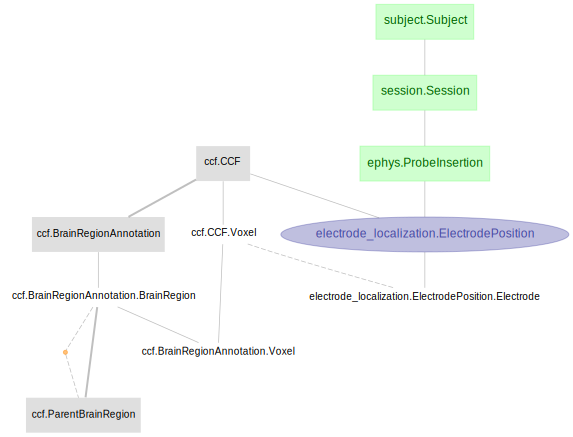

In [ ]:
(
    dj.Diagram(subject.Subject)
    + dj.Diagram(session.Session)
    + dj.Diagram(electrode_localization)
    + dj.Diagram(ccf)
)

As evident from the diagram, this data pipeline encompasses tables associated with electrode localization data. A few tables, such as `subject.Subject` and `session.Session`, while important for a complete pipeline, fall outside the scope of the `element-electrode-localization` tutorial, and will therefore, not be explored extensively here. The primary focus of this tutorial will be on the `coordinate_framework` and `electrode-localization` schemas.

### **Inspect and Query Coordinate Framework Tables**

The Allen Institute hosts [brain atlases](http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/) and [ontology trees](https://community.brain-map.org/t/allen-mouse-ccf-accessing-and-using-related-data-and-tools/359) that we'll use in the next section. The `tutorial_pipeline.py` script assumes this is your first atlas, and that you're using the 100μm resolution. Let's explore the data that was loaded into the `coordinate_framework` schema.

The `BrainRegionAnnotation` and it's part table `BrainRegion` store the relevant data from the Allen CCF.

In [5]:
ccf.BrainRegionAnnotation()

"ccf_id CCF ID, a.k.a atlas ID"
0


In [5]:
ccf.BrainRegionAnnotation.BrainRegion()

"ccf_id CCF ID, a.k.a atlas ID",acronym CHARACTER SET utf8 COLLATE utf8_bin,region_name,region_id,color_code Hex code of the color code of this region
0,6b,Layer 6b isocortex,16,8ADA87
0,a_a_a,Anterior amygdalar area,23,80C0E2
0,a_c_a,Anterior cingulate area,31,40A666
0,a_c_a1,Anterior cingulate area layer 1,572,40A666
0,a_c_a2/3,Anterior cingulate area layer 2/3,1053,40A666
0,a_c_a5,Anterior cingulate area layer 5,739,40A666
0,a_c_a6a,Anterior cingulate area layer 6a,179,40A666
0,a_c_a6b,Anterior cingulate area layer 6b,227,40A666
0,a_c_ad,Anterior cingulate area dorsal part,39,40A666
0,a_c_ad1,Anterior cingulate area dorsal part layer 1,935,40A666



The acronyms listed in the DataJoint table differ slightly from the CCF standard by substituting case-sensitive differences with [snake case](https://en.wikipedia.org/wiki/Snake_case). To lookup the snake case equivalent, use the `retrieve_acronym` function.

In [6]:
central_thalamus = ccf.BrainRegionAnnotation.retrieve_acronym("CM")
cranial_nerves = ccf.BrainRegionAnnotation.retrieve_acronym("cm")
print(f"CM: {central_thalamus}\ncm: {cranial_nerves}")

CM: c_m
cm: cm


For this tutorial, let's look at the dimensions of the central thalamus.

In [7]:
cm_voxels = ccf.BrainRegionAnnotation.Voxel() & f"acronym='{central_thalamus}'"
cm_voxels

"ccf_id CCF ID, a.k.a atlas ID",acronym CHARACTER SET utf8 COLLATE utf8_bin,x (um) Anterior-to-Posterior (AP axis),y (um) Superior-to-Inferior (DV axis),z (um) Left-to-Right (ML axis)
0,c_m,100,3300,4900
0,c_m,100,3300,5000
0,c_m,100,3300,5100
0,c_m,100,3300,5200
0,c_m,100,3300,5300
0,c_m,100,3300,6100
0,c_m,100,3300,6200
0,c_m,100,3300,6300
0,c_m,100,3300,6400
0,c_m,100,3300,6500


In [8]:
cm_x, cm_y, cm_z = cm_voxels.fetch("x", "y", "z")
print(
    f"The central thalamus extends from \n\tx = {min(cm_x)}  to x = {max(cm_x)}\n\t"
    + f"y = {min(cm_y)} to y = {max(cm_y)}\n\tz = {min(cm_z)} to z = {max(cm_z)}"
)

The central thalamus extends from 
	x = 100  to x = 8400
	y = 2600 to y = 7500
	z = 1700 to z = 9700


### **Electrode Localization**

If you have channel_location json files for your data, you can look at the position and regions associated with each electrode.

Let's use DataJoint's `.describe()` and `.heading` methods to view the dependencies and attributes of the `electrode_localization.ElectrodePosition` table.


In [6]:
print(electrode_localization.ElectrodePosition.describe())

-> ephys.ProbeInsertion
-> ccf.CCF



In [7]:
electrode_localization.ElectrodePosition.heading

# 
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
insertion_number     : tinyint unsigned             # 
ccf_id               : int                          # CCF ID, a.k.a atlas ID

As shown by the cells above, the `ElectrodePosition` table depends on entries in the coordinate_framework and ephys schemas. Once both schemas contain data, running `electrode_localization.ElectrodePosition.populate()` will automatically create entries in the `ElectrodePosition` and its part table `Electrode`. Let's view the attributes of the part table below:

In [8]:
electrode_localization.ElectrodePosition.Electrode.heading

subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
insertion_number     : tinyint unsigned             # 
ccf_id               : int                          # CCF ID, a.k.a atlas ID
probe_type           : varchar(32)                  # e.g. neuropixels_1.0
electrode            : int                          # electrode index, starts at 0
---
x                    : int                          # (um)  Anterior-to-Posterior (AP axis)
y                    : int                          # (um)  Superior-to-Inferior (DV axis)
z                    : int                          # (um)  Left-to-Right (ML axis)

Combined with the `coordinate_framework` schema, the `Electrode` part table above reveals the brain region location of each electrode in the NeuroPixel probe.

### Summary

Following this tutorial, we have:

- Covered the essential functionality and descriptions of the schemas in `element-electrode-localization`.


#### Documentation and DataJoint tutorials

+ Detailed [documentation on `element-electrode-localization`](https://datajoint.com/docs/elements/element-electrode-localization/0.1/)
+  [General `DataJoint-Python` interactive tutorials](https://github.com/datajoint/datajoint-tutorials), covering fundamentals, such as table tiers, query operations, fetch operations, automated computations with the make function, and more.
+ [Documentation for `DataJoint-Python`](https://datajoint.com/docs/core/datajoint-python/0.14/)

#### Run this tutorial on your own data

To run this tutorial notebook on your own data, please use the following steps:

+ Download the mysql-docker image for DataJoint and run the container according to the instructions provide in the repository.
+ Create a fork of this repository to your GitHub account.
+ Clone the repository and open the files using your IDE.
+ Add a code cell immediately after the first code cell in the notebook - we will setup the local connection using this cell. In this cell, type in the following code.

```python
import datajoint as dj
dj.config["database.host"] = "localhost"
dj.config["database.user"] = "<your-username>"
dj.config["database.password"] = "<your-password>"
dj.config["custom"] = {"imaging_root_data_dir": "path/to/your/data/dir",
"database_prefix": "<your-username_>"}
dj.config.save_local()
dj.conn()
```

    Run the code block above and proceed with the rest of the notebook.



